<a href="https://colab.research.google.com/github/armiro/Pneumothorax-Segmentation/blob/master/pnx_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import glob, cv2, gzip, gc

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Input, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, concatenate
from tensorflow.keras import Model, backend as K

In [2]:
# load the dataset
path = '/content/drive/MyDrive/Datasets/siim_acr_pneumothorax_seg/'
img_file = gzip.GzipFile(filename=path+'training_images.npy.gz', mode='r')
%time images = np.load(file=img_file)
msk_file = gzip.GzipFile(filename=path+'training_masks_resized.npy.gz', mode='r')
%time masks = np.load(file=msk_file)

print('shape of the dataset:', images.shape)
print('shape of the masks:', masks.shape)

CPU times: user 27.2 s, sys: 1.56 s, total: 28.8 s
Wall time: 44.9 s
CPU times: user 8.27 s, sys: 1.55 s, total: 9.82 s
Wall time: 9.85 s
shape of the dataset: (12047, 512, 512)
shape of the masks: (12047, 512, 512)


In [3]:
metadata = pd.read_csv(filepath_or_buffer=path+'converted-train-rle.csv', index_col=None)
print('metadata columns:', metadata.columns)
age = metadata.loc[:, 'PatientAge']
sex = metadata.loc[:, 'PatientSex']
view = metadata.loc[:, 'ImageView']

metadata columns: Index(['ImageId', 'PatientId', 'PatientAge', 'PatientSex', 'ImageView'], dtype='object')


In [ ]:
# preprocessing: for agile development, just load a small chunk of the dataset
chunk_size = 1000
images = np.expand_dims(images[:chunk_size], axis=-1)
images = images / 255.0
masks = np.expand_dims(masks[:chunk_size], axis=-1)
# no need to downscale, but masks are uint8 which must be casted to float64 for manual computations
# masks = masks / 255.0

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=18)

del images, masks
gc.collect()

In [5]:
# define metrics: dice coefficient (DICE/F1-score) and intersection over union (IoU/Jaccard)
def dice_coef(y_true, y_pred, smooth=1):
    overlap = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    total_area = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dsc = K.mean((2.0 * overlap + smooth) / (total_area + smooth), axis=0)
    return dsc


def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

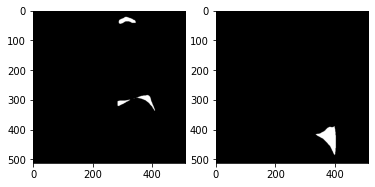

inter-dice is: tf.Tensor(0.0, shape=(), dtype=float64) and inter-jaccard is: tf.Tensor(0.0, shape=(), dtype=float64)
self-dice is: tf.Tensor(1.0, shape=(), dtype=float64) and self-jaccard is: tf.Tensor(1.0, shape=(), dtype=float64)


In [16]:
# test masks to see if both DSC ans IoU metrics are working correctly
im1 = np.expand_dims(y_train[2], axis=0).astype('float64')
im2 = np.expand_dims(y_train[3], axis=0).astype('float64')

plt.subplot(1, 2, 1)
plt.imshow(X=np.squeeze(im1, axis=(0, -1)), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(X=np.squeeze(im2, axis=(0, -1)), cmap='gray')
plt.show()

print('inter-dice is:', dice_coef(im1, im2), 'and inter-jaccard is:', iou_coef(im1, im2))
print('self-dice is:', dice_coef(im1, im1), 'and self-jaccard is:', iou_coef(im1, im1))

In [ ]:
# model architecture: vanilla unet
def vanilla_unet(input_size=(512,512,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])


model = vanilla_unet(input_size=(512, 512, 1))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef, iou_coef])
model.summary()
# tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
training = model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, verbose=1,
                     steps_per_epoch=len(X_train)//32.0)

In [ ]:
idx = 17

plt.imshow(X=X_train[idx].squeeze(), cmap='bone')
plt.show()
plt.imshow(X=y_train[idx].squeeze(), cmap='gray')
plt.show()
pred = model.predict(np.expand_dims(X_train[idx], axis=0))
plt.imshow(X=np.squeeze(pred, axis=(0, -1)), cmap='gray')
plt.show()